In [1]:
import pandas as pd
import numpy as np
import string

In [2]:
products = pd.read_csv("amazon_baby_subset.csv.zip")

In [3]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.as_matrix()
    label_sarray = dataframe[label]
    label_array = label_sarray.as_matrix()
    return(feature_matrix, label_array) 

In [4]:
imp_words = pd.read_json('important_words.json.zip')

In [5]:
imp_words = list(imp_words[0])

In [7]:
products = products.fillna({'review':''})

In [8]:
def remove_punctuation(text):
    trans_table = str.maketrans('','',string.punctuation)
    return text.translate(trans_table) 

In [9]:
products['review_clean'] = products['review'].apply(remove_punctuation)

In [10]:
for word in imp_words:
    products[word] = products['review_clean'].apply(lambda x:x.split().count(word))

In [13]:
train_ind = pd.read_json('module-4-assignment-train-idx.json.zip')
valid_ind = pd.read_json('module-4-assignment-validation-idx.json.zip')

In [25]:
train = products.iloc[train_ind[0]]
valid = products.iloc[valid_ind[0]]

In [26]:
feature_matrix_train, sentiment_train = get_numpy_data(train, imp_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(valid, imp_words, 'sentiment') 

C:\Users\akirar1230\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
def predict_probability(feature_matrix, coefficients):
    score = np.dot(feature_matrix, coefficients)
    predictions = 1/(1+np.exp(-score))
    
    return predictions

In [29]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    derv = np.dot(feature,errors)
    if (feature_is_constant):
        return derv
    else:
        return derv - 2*l2_penalty*coefficient

In [30]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp

In [32]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        ## YOUR CODE HERE
        predictions = predict_probability(coefficients=coefficients,feature_matrix=feature_matrix)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            ## YOUR CODE HERE
            derivative = feature_derivative_with_L2(errors, feature_matrix[:,j], coefficients[j], l2_penalty, is_intercept)
            
            # add the step size times the derivative to the current coefficient
            ## YOUR CODE HERE
            coefficients[j] += step_size*derivative
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print ('iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp))
    return coefficients

In [37]:
L2_penalty_list = [0, 4, 10, 1e2, 1e3, 1e5]
initial_coefficients = np.zeros(feature_matrix_train.shape[1])
step_size = 5e-6
max_iter = 501

In [38]:
coefficients_list = [logistic_regression_with_L2(feature_matrix_train, sentiment_train, initial_coefficients, 
  step_size, l2_penalty, max_iter) for l2_penalty in L2_penalty_list]

iteration   0: log likelihood of observed labels = -29179.39138303
iteration   1: log likelihood of observed labels = -29003.71259047
iteration   2: log likelihood of observed labels = -28834.66187288
iteration   3: log likelihood of observed labels = -28671.70781507
iteration   4: log likelihood of observed labels = -28514.43078198
iteration   5: log likelihood of observed labels = -28362.48344665
iteration   6: log likelihood of observed labels = -28215.56713122
iteration   7: log likelihood of observed labels = -28073.41743783
iteration   8: log likelihood of observed labels = -27935.79536396
iteration   9: log likelihood of observed labels = -27802.48168669
iteration  10: log likelihood of observed labels = -27673.27331484
iteration  11: log likelihood of observed labels = -27547.98083656
iteration  12: log likelihood of observed labels = -27426.42679977
iteration  13: log likelihood of observed labels = -27308.44444728
iteration  14: log likelihood of observed labels = -27193.8767

iteration   7: log likelihood of observed labels = -28162.56976044
iteration   8: log likelihood of observed labels = -28046.29387744
iteration   9: log likelihood of observed labels = -27935.93902900
iteration  10: log likelihood of observed labels = -27831.15045502
iteration  11: log likelihood of observed labels = -27731.59955260
iteration  12: log likelihood of observed labels = -27636.98108219
iteration  13: log likelihood of observed labels = -27547.01092670
iteration  14: log likelihood of observed labels = -27461.42422295
iteration  15: log likelihood of observed labels = -27379.97375625
iteration  20: log likelihood of observed labels = -27027.18208317
iteration  30: log likelihood of observed labels = -26527.22737267
iteration  40: log likelihood of observed labels = -26206.59048765
iteration  50: log likelihood of observed labels = -25995.96903148
iteration  60: log likelihood of observed labels = -25854.95710284
iteration  70: log likelihood of observed labels = -25759.0810

In [40]:
valid_predictions_list = list()
for i in range(len(coefficients_list)):
    valid_predictions_list.append(predict_probability(feature_matrix=feature_matrix_valid,coefficients=coefficients_list[i]))

In [45]:
coefficients_name = ['coefficients_0_penalty', 'coefficients_4_penalty', 'coefficients_10_penalty', 'coefficients_1e2_penalty', 
                     'coefficients_1e3_penalty', 'coefficients_1e5_penalty' ]
coefficients_list_dict = dict(zip(coefficients_name,coefficients_list))

In [63]:
zero_pen_coeff = coefficients_list_dict['coefficients_0_penalty'][1:]

In [67]:
zero_pen_coeff = list(zero_pen_coeff)

In [69]:
word_coefficient_0_penalty_tuples = [(word, coefficient) for word, coefficient in zip(imp_words, zero_pen_coeff)]
word_coefficient_0_penalty_tuples = sorted(word_coefficient_0_penalty_tuples, key=lambda x:x[1], reverse=True)

In [73]:
postive_words = word_coefficient_0_penalty_tuples[:5]

In [74]:
negative_words = word_coefficient_0_penalty_tuples[-5:]

In [83]:
new_dict = dict(coefficients_list_dict)

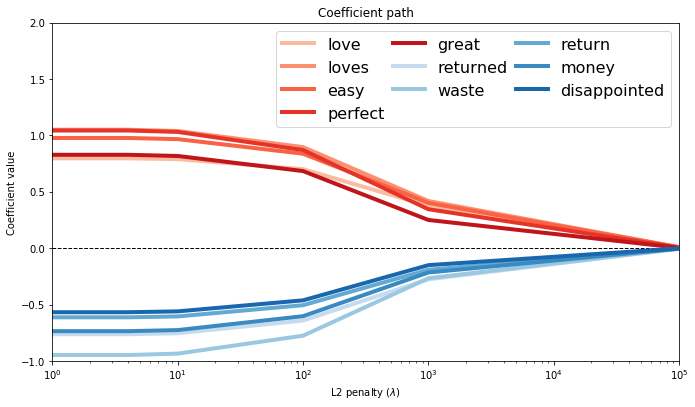

In [115]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table[table['word'].isin(positive_words)]
    table_negative_words = table[table['word'].isin(negative_words)]
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].as_matrix().flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].as_matrix().flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()

make_coefficient_plot(word_penality_coef, postive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

In [77]:
postive_words = [x for x,y in postive_words]

In [79]:
negative_words = [x for x,y in negative_words]

In [85]:
new_dict.update({'word': ['(intercept)'] + imp_words})

In [87]:
word_penality_coef = pd.DataFrame(new_dict)

In [114]:
word_penality_coef = word_penality_coef[new_columns]

In [106]:
new_columns = word_penality_coef.columns.tolist()

In [97]:
new_columns = new_columns[-1:] + new_columns[:-1]

In [99]:
word_penality_coef = word_penality_coef[new_columns]

In [112]:
new_columns = new_columns[0:2]+new_columns[-1:]+new_columns[2:-1]

In [116]:
def model_acc(feat_matrix,sentiment,coeffs):
    score = np.dot(feat_matrix,coeffs)
    predictions = np.array([1 if (sc>0) else -1 for sc in score])
    correct = np.sum(predictions == sentiment)
    all_data = len(feat_matrix)
    return correct / all_data

In [122]:
model_acc(feature_matrix_train,sentiment_train,coefficients_list_dict['coefficients_0_penalty'])

0.7851561577866434

In [120]:
coefficients_list_dict

{'coefficients_0_penalty': array([-6.37421352e-02,  7.40730059e-02,  1.27525058e-02,  8.01624990e-01,
         1.05855398e+00, -1.04152191e-04, -2.87021444e-01, -3.38447399e-03,
         9.84558820e-01,  5.24419456e-01, -8.69675407e-02,  2.08912434e-01,
         4.53866487e-01, -1.96835211e-01,  1.58163325e-01, -1.79058177e-02,
         1.28396325e-01, -7.24293854e-02, -1.51817046e-01, -2.63330304e-01,
         1.56507228e-01,  2.63417760e-01, -1.32474753e-02,  1.05248405e+00,
        -3.75326583e-02, -3.29713873e-04, -6.79948371e-02,  1.93363694e-01,
         1.88508247e-01, -2.68954361e-01,  9.62841996e-02,  3.58309842e-01,
        -4.63096879e-02, -3.68678195e-01,  8.35693208e-01,  4.29393687e-01,
        -6.53274724e-03, -1.18953292e-01,  4.52597544e-02, -1.05433750e-01,
        -1.40179533e-01,  1.15329513e-01,  4.70226839e-02,  2.77177536e-02,
        -1.93377062e-01,  2.65797426e-01,  7.83957751e-02, -1.76600523e-01,
         3.61782536e-01,  1.02765639e-01, -2.71592217e-01,  2.